## Libraries

In [1]:
# Install Libraries
!pip install --quiet --upgrade yfinance
!pip install --quiet optuna-integration
!pip install --quiet torch_optimizer
!pip install --quiet bitsandbytes accelerate 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.9/117.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 71.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.

In [2]:
# Standard libraries
import os
import time
import math
import warnings
from typing import List

# Data processing
import numpy as np
import pandas as pd
import yfinance as yf
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt

# PyTorch core
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset
from torch.nn.utils import weight_norm

# Suppress warnings
warnings.filterwarnings('ignore')




## Functions

In [3]:
# Utils Tools

plt.switch_backend('agg')


def adjust_learning_rate(optimizer, epoch, args):
    # lr = args.learning_rate * (0.2 ** (epoch // 2))
    if args.lradj == 'type1':
        lr_adjust = {epoch: args.learning_rate * (0.5 ** ((epoch - 1) // 1))}
    elif args.lradj == 'type2':
        lr_adjust = {
            2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
            10: 5e-7, 15: 1e-7, 20: 5e-8
        }
    elif args.lradj == 'type3':
        lr_adjust = {epoch: args.learning_rate if epoch < 3 else args.learning_rate * (0.9 ** ((epoch - 3) // 1))}
    elif args.lradj == "cosine":
        lr_adjust = {epoch: args.learning_rate /2 * (1 + math.cos(epoch / args.train_epochs * math.pi))}
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))


class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
        self.val_loss_min = val_loss


class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


class StandardScaler2():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return (data * self.std) + self.mean


def visual(true, preds=None, name='./pic/test.pdf'):
    """
    Results visualization
    """
    plt.figure()
    plt.plot(true, label='GroundTruth', linewidth=2, color='#ff7f0e', zorder=2)
    if preds is not None:
        plt.plot(preds, label='Prediction', linewidth=2, color='#1f77b4', zorder=1)
    plt.legend()
    plt.savefig(name, bbox_inches='tight')


def adjustment(gt, pred):
    anomaly_state = False
    for i in range(len(gt)):
        if gt[i] == 1 and pred[i] == 1 and not anomaly_state:
            anomaly_state = True
            for j in range(i, 0, -1):
                if gt[j] == 0:
                    break
                else:
                    if pred[j] == 0:
                        pred[j] = 1
            for j in range(i, len(gt)):
                if gt[j] == 0:
                    break
                else:
                    if pred[j] == 0:
                        pred[j] = 1
        elif gt[i] == 0:
            anomaly_state = False
        if anomaly_state:
            pred[i] = 1
    return gt, pred


def cal_accuracy(y_pred, y_true):
    return np.mean(y_pred == y_true)


# From: gluonts/src/gluonts/time_feature/_base.py
# Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License").
# You may not use this file except in compliance with the License.
# A copy of the License is located at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# or in the "license" file accompanying this file. This file is distributed
# on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
# express or implied. See the License for the specific language governing
# permissions and limitations under the License.




class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"


class SecondOfMinute(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5


class MinuteOfHour(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5


class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5


class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5


class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5


class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5


class MonthOfYear(TimeFeature):
    """Month of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5


class WeekOfYear(TimeFeature):
    """Week of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.isocalendar().week - 1) / 52.0 - 0.5


def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)


def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])




In [4]:
# Dataset Custom Class and Data Provider for time series forecasting


class Dataset_Custom(Dataset):
    def __init__(self, args, df=None, flag='train', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, timeenc=0, freq='h', seasonal_patterns=None):
        # info
        self.args = args
        if size is None:
            self.seq_len = 96
            self.label_len = 48
            self.pred_len = 24
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]

        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq
        self.root_path = args.root_path if hasattr(args, 'root_path') else './'
        self.data_path = args.data_path if hasattr(args, 'data_path') else data_path
        self.seasonal_patterns = seasonal_patterns
        
        # Pass df or load from file
        self.df = df  
        self.__read_data__()

    def __read_data__(self, df=None):
        self.scaler = StandardScaler()

        df_raw = self.df

        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        cols = list(df_raw.columns)
        cols.remove(self.target)
        cols.remove('date')
        df_raw = df_raw[['date'] + cols + [self.target]]
        num_train = int(len(df_raw) * 0.7)
        num_test = int(len(df_raw) * 0.2)
        num_vali = len(df_raw) - num_train - num_test
        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]
        border2s = [num_train, num_train + num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp


    def __getitem__(self, index):
        # Ensure valid slicing
        s_begin = index
        s_end = min(s_begin + self.seq_len, len(self.data_x))
        r_begin = s_end - self.label_len
        r_end = min(r_begin + self.label_len + self.pred_len, len(self.data_y))
    
        # Slice sequences
        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]
    
        # Pad if needed
        if seq_x.shape[0] < self.seq_len:
            pad_len = self.seq_len - seq_x.shape[0]
            seq_x = np.pad(seq_x, ((0, pad_len), (0, 0)), 'constant')
    
        if seq_x_mark.shape[0] < self.seq_len:
            pad_len = self.seq_len - seq_x_mark.shape[0]
            seq_x_mark = np.pad(seq_x_mark, ((0, pad_len), (0, 0)), 'constant')
    
        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)




data_dict = {
    'custom': Dataset_Custom,
}


def data_provider(args, flag):
    Data = data_dict[args.data_class]
    timeenc = 0 if args.embed != 'timeF' else 1
    shuffle_flag = False if (flag == 'test' or flag == 'TEST') else True
    drop_last = False
    batch_size = args.batch_size
    freq = args.freq

    data_set = Data(
        args = args,
        df = args.data,
        flag=flag,
        size=[args.seq_len, args.label_len, args.pred_len],
        features=args.features,
        target=args.target,
        timeenc=timeenc,
        freq=freq,
        seasonal_patterns=args.seasonal_patterns
    )

    print(flag, len(data_set))
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=args.num_workers,
        drop_last=drop_last)
    
    return data_set, data_loader


In [5]:
# Time Feature Extraction

from typing import List

from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset


class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"


class SecondOfMinute(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5


class MinuteOfHour(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5


class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5


class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5


class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5


class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5


class MonthOfYear(TimeFeature):
    """Month of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5


class WeekOfYear(TimeFeature):
    """Week of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.isocalendar().week - 1) / 52.0 - 0.5


def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)


def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])

In [6]:
# Transformer Architecture

class FlattenHead(nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = nn.Flatten(start_dim=-2)
        self.linear = nn.Linear(nf, target_window)
        self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x

class Model(nn.Module):
    def __init__(self, configs):
        super().__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        patch_len = configs.patch_len
        stride = configs.stride
        padding = stride

        self.patch_embedding = PatchEmbedding(configs.d_model, patch_len, stride, padding, configs.dropout)
        self.head_nf = configs.d_model * int((configs.seq_len - patch_len) / stride + 2)
        self.head = FlattenHead(configs.enc_in, self.head_nf, configs.d_model, head_dropout=configs.dropout)
        self.project_embedding = DataEmbedding_inverted(configs.seq_len, configs.d_model, configs.embed, configs.freq,
                                                    configs.dropout)

        self.gate_w1 = nn.Linear(configs.d_model, configs.d_model)
        self.gate_w2 = nn.Linear(configs.d_model, configs.d_model)
        self.gate_w3 = nn.Linear(configs.d_model, configs.d_model)
        self.gate_w4 = nn.Linear(configs.d_model, configs.d_model)
        self.gate_sigmoid = nn.Sigmoid()

        enc_layers_temporal = nn.TransformerEncoderLayer(
                                    d_model=configs.d_model,
                                    nhead=configs.n_heads,
                                    dim_feedforward=configs.d_ff,
                                    dropout=configs.dropout,
                                    layer_norm_eps=1e-5,
                                    batch_first=True, 
                                    norm_first=True 
                                )

        enc_layers_feature = nn.TransformerEncoderLayer(
                                    d_model=configs.d_model,
                                    nhead=configs.n_heads,
                                    dim_feedforward=configs.d_ff,
                                    dropout=configs.dropout,
                                    layer_norm_eps=1e-5,
                                    batch_first=True,
                                    norm_first=True
                                )
        
        # temporal-wise attention
        self.enc_temporal = nn.TransformerEncoder(enc_layers_temporal, num_layers=configs.e_layers)

        # variate-wise attention
        self.enc_variate = nn.TransformerEncoder(enc_layers_feature, num_layers=configs.e_layers)

        # output projection
        self.projection = nn.Linear(configs.d_model, configs.pred_len, bias=True)
    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        # x_enc: [B, L, D]
        
        # Normalization
        means = x_enc.mean(1, keepdim=True).detach()
        x_enc = x_enc - means
        stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
        x_enc /= stdev
    
        # Convert [B, L, D] → [B, D, L] before embedding
        x_enc_for_embedding = x_enc.permute(0, 2, 1)
        global_embedding = self.project_embedding(x_enc_for_embedding, None)
    
        # Patching
        x_enc = x_enc.permute(0, 2, 1) 
        enc_out, n_vars = self.patch_embedding(x_enc)
    
        # Temporal-wise attention
        enc_out = self.enc_temporal(enc_out)
        enc_out = torch.reshape(enc_out, (-1, n_vars, enc_out.shape[-2], enc_out.shape[-1]))
        enc_out = enc_out.permute(0, 1, 3, 2)
        temporal_dependency_embedding = self.head(enc_out)
    
        # Gate 1
        gate = self.gate_sigmoid(self.gate_w1(global_embedding) + self.gate_w2(temporal_dependency_embedding))
        enc_out = gate * global_embedding + (1 - gate) * temporal_dependency_embedding
    
        # Variate-wise attention
        enc_out_cross = self.enc_variate(enc_out)
    
        # Gate 2
        gate = self.gate_sigmoid(self.gate_w3(enc_out) + self.gate_w4(enc_out_cross))
        enc_out = gate * enc_out + (1 - gate) * enc_out_cross
    
        # Decoder
        dec_out = self.projection(enc_out).permute(0, 2, 1)[:, :, :n_vars]
    
        # De-Normalization
        dec_out = dec_out * (stdev[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
        dec_out = dec_out + (means[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
    
        return dec_out

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
        return dec_out[:, -self.pred_len:, :]  # [B, L, D]

In [37]:
# Training and testing the model
# Import necessary libraries - uncommented these imports



class Exp_Basic(object):
    def __init__(self, args):
        self.args = args
        self.model_dict = {
            'Gateformer': Gateformer
        }

        self.device = self._acquire_device()
        self.model = self._build_model().to(self.device)
        
    def _build_model(self):
        raise NotImplementedError
        return None

    def _acquire_device(self):
        if self.args.use_gpu:
            os.environ["CUDA_VISIBLE_DEVICES"] = str(
                self.args.gpu) if not self.args.use_multi_gpu else self.args.devices
            device = torch.device('cuda:{}'.format(self.args.gpu))
            print('Use GPU: cuda:{}'.format(self.args.gpu))
        else:
            device = torch.device('cpu')
            print('Use CPU')
        return device

    def _get_data(self, flag):
        raise NotImplementedError

    def vali(self):
        raise NotImplementedError

    def train(self):
        raise NotImplementedError

    def test(self):
        raise NotImplementedError


class Exp_Long_Term_Forecast(Exp_Basic):
    def __init__(self, args):
        super(Exp_Long_Term_Forecast, self).__init__(args)

    def _build_model(self):
        model = self.model_dict[self.args.model].Model(self.args).float()

        if self.args.use_multi_gpu and self.args.use_gpu:
            model = nn.DataParallel(model, device_ids=self.args.device_ids)
        return model

    def _get_data(self, flag):
        data_set, data_loader = data_provider(self.args, flag)
        return data_set, data_loader

    def _select_optimizer(self):
        model_optim = optim.Adam(self.model.parameters(), lr=self.args.learning_rate)
        return model_optim

    def _select_criterion(self):
        criterion = nn.MSELoss()
        return criterion
 
    def vali(self, vali_data, vali_loader, criterion):
        total_loss = []
        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(vali_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float()

                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                else:
                    outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                f_dim = -1 if self.args.features == 'MS' else 0
                outputs = outputs[:, -self.args.pred_len:, f_dim:]
                batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)

                pred = outputs.detach().cpu()
                true = batch_y.detach().cpu()

                loss = criterion(pred, true)

                total_loss.append(loss)
        total_loss = np.average(total_loss)
        self.model.train()
        return total_loss

    def train(self, setting):
        train_data, train_loader = self._get_data(flag='train')
        vali_data, vali_loader = self._get_data(flag='val')
        test_data, test_loader = self._get_data(flag='test')

        path = os.path.join(self.args.checkpoints, setting)
        if not os.path.exists(path):
            os.makedirs(path)

        time_now = time.time()

        train_steps = len(train_loader)
        early_stopping = EarlyStopping(patience=self.args.patience, verbose=True)

        model_optim = self._select_optimizer()
        criterion = self._select_criterion()

        if self.args.use_amp:
            scaler = torch.cuda.amp.GradScaler()
        
        for epoch in range(self.args.train_epochs):
            iter_count = 0
            train_loss = []

            self.model.train()
            epoch_time = time.time()
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
                iter_count += 1
                model_optim.zero_grad()
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float().to(self.device)
                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)

                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                        f_dim = -1 if self.args.features == 'MS' else 0
                        outputs = outputs[:, -self.args.pred_len:, f_dim:]
                        batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                        loss = criterion(outputs, batch_y)
                        train_loss.append(loss.item())
                    
                    # Backward and optimize with scaler
                    scaler.scale(loss).backward()
                    scaler.step(model_optim)
                    scaler.update()
                else:
                    outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                    
                    f_dim = -1 if self.args.features == 'MS' else 0
                    outputs = outputs[:, -self.args.pred_len:, f_dim:]
                    batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                    loss = criterion(outputs, batch_y)
                    train_loss.append(loss.item())
                    
                    # Backward and optimize
                    loss.backward()
                    model_optim.step()

                if (i + 1) % 100 == 0:
                    print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(
                        i + 1, epoch + 1, loss.item()))
                    speed = (time.time() - time_now) / iter_count
                    left_time = speed * ((self.args.train_epochs - epoch) * train_steps - i)
                    print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
                    iter_count = 0
                    time_now = time.time()

            train_loss = np.average(train_loss)
            vali_loss = self.vali(vali_data, vali_loader, criterion)
            test_loss = self.vali(test_data, test_loader, criterion)

            print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} Test Loss: {4:.7f}".format(
                epoch + 1, train_steps, train_loss, vali_loss, test_loss))
            
            # Learning rate adjustment
            adjust_learning_rate(model_optim, epoch + 1, self.args)
            
            # Early stopping
            early_stopping(vali_loss, self.model, path)
            if early_stopping.early_stop:
                print("Early stopping")
                break

            # Save model after each epoch
            torch.save(self.model.state_dict(), path + '/' + 'checkpoint.pth')

        # Load the best model
        best_model_path = path + '/' + 'checkpoint.pth'
        self.model.load_state_dict(torch.load(best_model_path))
        
        return self.model

    def test(self, setting):
        test_data, test_loader = self._get_data(flag='test')
        
        # Create folder for saving results
        folder_path = './results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        preds = []
        trues = []
            
        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float().to(self.device)

                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                else:
                    outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                f_dim = -1 if self.args.features == 'MS' else 0
                outputs = outputs[:, -self.args.pred_len:, :]
                batch_y = batch_y[:, -self.args.pred_len:, :].to(self.device)
                outputs = outputs.detach().cpu().numpy()
                batch_y = batch_y.detach().cpu().numpy()
                if test_data.scale and self.args.inverse:
                    shape = batch_y.shape
                    if outputs.shape[-1] != batch_y.shape[-1]:
                        outputs = np.tile(outputs, [1, 1, int(batch_y.shape[-1] / outputs.shape[-1])])
                    outputs = test_data.inverse_transform(outputs.reshape(shape[0] * shape[1], -1)).reshape(shape)
                    batch_y = test_data.inverse_transform(batch_y.reshape(shape[0] * shape[1], -1)).reshape(shape)

                outputs = outputs[:, :, f_dim:]
                batch_y = batch_y[:, :, f_dim:]

                pred = outputs
                true = batch_y

                preds.append(pred)
                trues.append(true)
                if i % 20 == 0:
                    input = batch_x.detach().cpu().numpy()
                    if test_data.scale and self.args.inverse:
                        shape = input.shape
                        input = test_data.inverse_transform(input.reshape(shape[0] * shape[1], -1)).reshape(shape)
                    gt = np.concatenate((input[0, :, -1], true[0, :, -1]), axis=0)
                    pd = np.concatenate((input[0, :, -1], pred[0, :, -1]), axis=0)
                    visual(gt, pd, os.path.join(folder_path, str(i) + '.pdf'))

        preds = np.concatenate(preds, axis=0)
        trues = np.concatenate(trues, axis=0)
        print('test shape:', preds.shape, trues.shape)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
        print('test shape:', preds.shape, trues.shape)

        mae, mse, rmse, mape, mspe, r2 = metric(preds, trues)
        print('mse:{}, mae:{}, r2:{}'.format(mse, mae, r2))
        f = open("result_long_term_forecast.txt", 'a')
        f.write(setting + "  \n")
        f.write('mse:{}, mae:{}, r2:{}'.format(mse, mae, r2))
        f.write('\n')
        f.write('\n')
        f.close()

        np.save(folder_path + 'metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(folder_path + 'pred.npy', preds)
        np.save(folder_path + 'true.npy', trues)

        return mae, mse




In [8]:
# Embedding classes


class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(
            self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6,
                    'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x) + self.position_embedding(x)
        else:
            x = self.value_embedding(
                x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)


class DataEmbedding_inverted(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding_inverted, self).__init__()
        self.value_embedding = nn.Linear(c_in, d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = x.permute(0, 2, 1)
        # x: [Batch Variate Time]
        if x_mark is None:
            x = self.value_embedding(x)
        else:
            x = self.value_embedding(torch.cat([x, x_mark.permute(0, 2, 1)], 1))
        # x: [Batch Variate d_model]
        return self.dropout(x)


class DataEmbedding_wo_pos(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding_wo_pos, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x)
        else:
            x = self.value_embedding(x) + self.temporal_embedding(x_mark)
        return self.dropout(x)


class PatchEmbedding(nn.Module):
    def __init__(self, d_model, patch_len, stride, padding, dropout):
        super(PatchEmbedding, self).__init__()
        # Patching
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch_layer = nn.ReplicationPad1d((0, padding))

        # Backbone, Input encoding: projection of feature vectors onto a d-dim vector space
        self.value_embedding = nn.Linear(patch_len, d_model, bias=False)

        # Positional embedding
        self.position_embedding = PositionalEmbedding(d_model)

        # Residual dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # do patching
        n_vars = x.shape[1]
        x = self.padding_patch_layer(x)
        x = x.unfold(dimension=-1, size=self.patch_len, step=self.stride)
        x = torch.reshape(x, (x.shape[0] * x.shape[1], x.shape[2], x.shape[3]))
        # Input encoding
        x = self.value_embedding(x) + self.position_embedding(x)
        return self.dropout(x), n_vars

In [9]:
# Gateformer Model

class FlattenHead(nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = nn.Flatten(start_dim=-2)
        self.linear = nn.Linear(nf, target_window)
        self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x

class Model(nn.Module):
    def __init__(self, configs):
        super().__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        patch_len = configs.patch_len
        stride = configs.stride
        padding = stride

        self.patch_embedding = PatchEmbedding(configs.d_model, patch_len, stride, padding, configs.dropout)
        self.head_nf = configs.d_model * int((configs.seq_len - patch_len) / stride + 2)
        self.head = FlattenHead(configs.enc_in, self.head_nf, configs.d_model, head_dropout=configs.dropout)
        self.project_embedding = DataEmbedding_inverted(configs.seq_len, configs.d_model, configs.embed, configs.freq,
                                                    configs.dropout)

        self.gate_w1 = nn.Linear(configs.d_model, configs.d_model)
        self.gate_w2 = nn.Linear(configs.d_model, configs.d_model)
        self.gate_w3 = nn.Linear(configs.d_model, configs.d_model)
        self.gate_w4 = nn.Linear(configs.d_model, configs.d_model)
        self.gate_sigmoid = nn.Sigmoid()

        enc_layers_temporal = nn.TransformerEncoderLayer(
                                    d_model=configs.d_model,
                                    nhead=configs.n_heads,
                                    dim_feedforward=configs.d_ff,
                                    dropout=configs.dropout,
                                    layer_norm_eps=1e-5,
                                    batch_first=True, 
                                    norm_first=True 
                                )

        enc_layers_feature = nn.TransformerEncoderLayer(
                                    d_model=configs.d_model,
                                    nhead=configs.n_heads,
                                    dim_feedforward=configs.d_ff,
                                    dropout=configs.dropout,
                                    layer_norm_eps=1e-5,
                                    batch_first=True,
                                    norm_first=True
                                )
        
        # temporal-wise attention
        self.enc_temporal = nn.TransformerEncoder(enc_layers_temporal, num_layers=configs.e_layers)

        # variate-wise attention
        self.enc_variate = nn.TransformerEncoder(enc_layers_feature, num_layers=configs.e_layers)

        # output projection
        self.projection = nn.Linear(configs.d_model, configs.pred_len, bias=True)

    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        
        # x_enc: [B, L, D]
        # Normalization
        means = x_enc.mean(1, keepdim=True).detach()
        x_enc = x_enc - means
        stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
        x_enc /= stdev
        
        global_embedding = self.project_embedding(x_enc, None) # global_embedding: [B, D, d_model]

        # patching
        x_enc = x_enc.permute(0, 2, 1) 
        enc_out, n_vars = self.patch_embedding(x_enc) # enc_out: [B * D, patch_num, d_model]

        # temporal-wise attention
        enc_out = self.enc_temporal(enc_out) # enc_out: [B * D, patch_num, d_model]
        enc_out = torch.reshape(enc_out, (-1, n_vars, enc_out.shape[-2], enc_out.shape[-1]))
        enc_out = enc_out.permute(0, 1, 3, 2)
        temporal_dependency_embedding = self.head(enc_out) # temporal_dependency_embedding: [B, D, d_model]

        # gate
        gate = self.gate_sigmoid(self.gate_w1(global_embedding) + self.gate_w2(temporal_dependency_embedding))
        enc_out = gate * global_embedding + (1 - gate) * temporal_dependency_embedding

        # variate-wise attention
        enc_out_cross = self.enc_variate(enc_out)

        # gate
        gate = self.gate_sigmoid(self.gate_w3(enc_out) + self.gate_w4(enc_out_cross))
        enc_out = gate * enc_out + (1 - gate) * enc_out_cross

        # Decoder
        dec_out = self.projection(enc_out).permute(0, 2, 1)[:, :, :n_vars]  # dec_out: [B, pred_len, D]

        # De-Normalization
        dec_out = dec_out * (stdev[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
        dec_out = dec_out + (means[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
        return dec_out

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
        return dec_out[:, -self.pred_len:, :]  # [B, L, D]

class Gateformer:
    Model = Model

In [10]:
# Mask

class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask


class ProbMask():
    def __init__(self, B, H, L, index, scores, device="cpu"):
        _mask = torch.ones(L, scores.shape[-1], dtype=torch.bool).to(device).triu(1)
        _mask_ex = _mask[None, None, :].expand(B, H, L, scores.shape[-1])
        indicator = _mask_ex[torch.arange(B)[:, None, None],
                    torch.arange(H)[None, :, None],
                    index, :].to(device)
        self._mask = indicator.view(scores.shape).to(device)

    @property
    def mask(self):
        return self._mask

In [38]:
# Metrics


def RSE(pred, true):
    return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))


def CORR(pred, true):
    u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)
    d = np.sqrt(((true - true.mean(0)) ** 2 * (pred - pred.mean(0)) ** 2).sum(0))
    return (u / d).mean(-1)


def MAE(pred, true):
    return np.mean(np.abs(true - pred))


def MSE(pred, true):
    return np.mean((true - pred) ** 2)


def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))


def MAPE(pred, true):
    return np.mean(np.abs((true - pred) / true))


def MSPE(pred, true):
    return np.mean(np.square((true - pred) / true))


def R2(pred, true):
    # pred: [B, L, D], true: [B, L, D]
    se = np.sum((true - pred) ** 2, axis=(0, 1))
    st = np.sum((true - np.mean(true, axis=(0, 1))) ** 2, axis=(0, 1))
    r2 = 1 - se / st
    return r2.mean()  # average over features if multivariate

def metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    r2 = R2(pred, true)

    return mae, mse, rmse, mape, mspe, r2

In [12]:
# Arguments

def print_args(args):
    print("\033[1m" + "Basic Config" + "\033[0m")
    print(f'  {"Model ID:":<20}{args.model_id:<20}{"Model:":<20}{args.model:<20}')
    print()

    print("\033[1m" + "Data Loader" + "\033[0m")
    print(f'  {"Data:":<20}{args.data:<20}{"Root Path:":<20}{args.root_path:<20}')
    print(f'  {"Data Path:":<20}{args.data_path:<20}{"Features:":<20}{args.features:<20}')
    print(f'  {"Target:":<20}{args.target:<20}{"Freq:":<20}{args.freq:<20}')
    print(f'  {"Checkpoints:":<20}{args.checkpoints:<20}')
    print()

    print("\033[1m" + "Forecasting Task" + "\033[0m")
    print(f'  {"Seq Len:":<20}{args.seq_len:<20}{"Label Len:":<20}{args.label_len:<20}')
    print(f'  {"Pred Len:":<20}{args.pred_len:<20}{"Seasonal Patterns:":<20}{args.seasonal_patterns:<20}')
    print(f'  {"Inverse:":<20}{args.inverse:<20}')
    print()

    print("\033[1m" + "Model Parameters" + "\033[0m")
    print(f'  {"Enc In:":<20}{args.enc_in:<20}{"Dec In:":<20}{args.dec_in:<20}')
    print(f'  {"C Out:":<20}{args.c_out:<20}{"d model:":<20}{args.d_model:<20}')
    print(f'  {"n heads:":<20}{args.n_heads:<20}{"e layers:":<20}{args.e_layers:<20}')
    print(f'  {"d layers:":<20}{args.d_layers:<20}{"d FF:":<20}{args.d_ff:<20}')
    print(f'  {"Moving Avg:":<20}{args.moving_avg:<20}{"Factor:":<20}{args.factor:<20}')
    print(f'  {"Distil:":<20}{args.distil:<20}{"Dropout:":<20}{args.dropout:<20}')
    print(f'  {"Embed:":<20}{args.embed:<20}{"Activation:":<20}{args.activation:<20}')
    print()

    print("\033[1m" + "Run Parameters" + "\033[0m")
    print(f'  {"Num Workers:":<20}{args.num_workers:<20}{"Itr:":<20}{args.itr:<20}')
    print(f'  {"Train Epochs:":<20}{args.train_epochs:<20}{"Batch Size:":<20}{args.batch_size:<20}')
    print(f'  {"Patience:":<20}{args.patience:<20}{"Learning Rate:":<20}{args.learning_rate:<20}')
    print(f'  {"Des:":<20}{args.des:<20}{"Loss:":<20}{args.loss:<20}')
    print(f'  {"Lradj:":<20}{args.lradj:<20}{"Use Amp:":<20}{args.use_amp:<20}')
    print()

    print("\033[1m" + "GPU" + "\033[0m")
    print(f'  {"Use GPU:":<20}{args.use_gpu:<20}{"GPU:":<20}{args.gpu:<20}')
    print(f'  {"Use Multi GPU:":<20}{args.use_multi_gpu:<20}{"Devices:":<20}{args.devices:<20}')
    print()

## Yahoo Finance

In [43]:
# Technical ndicators

def calculate_sma(df, window):
    return df['Close'].rolling(window=window).mean()

def calculate_ema(df, window):
    return df['Close'].ewm(span=window, adjust=False).mean()

def calculate_macd(df):
    short_ema = df['Close'].ewm(span=12, adjust=False).mean()
    long_ema = df['Close'].ewm(span=26, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

def calculate_rsi(df):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_bollinger_bands(df):
    middle_bb = df['Close'].rolling(window=20).mean()
    upper_bb = middle_bb + 2 * df['Close'].rolling(window=20).std()
    lower_bb = middle_bb - 2 * df['Close'].rolling(window=20).std()
    return middle_bb, upper_bb, lower_bb

def calculate_stochastic_oscillator(df):
    lowest_low = df['Low'].rolling(window=14).min()
    highest_high = df['High'].rolling(window=14).max()
    slowk = ((df['Close'] - lowest_low) / (highest_high - lowest_low)) * 100
    slowd = slowk.rolling(window=3).mean()
    return slowk, slowd

def calculate_cmf(df, window=20):
    mfv = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low']) * df['Volume']
    cmf = mfv.rolling(window=window).sum() / df['Volume'].rolling(window=window).sum()
    return cmf

def calculate_cci(df, window=20):
    """Calculate Commodity Channel Index (CCI)."""
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    sma = typical_price.rolling(window=window).mean()
    mean_deviation = (typical_price - sma).abs().rolling(window=window).mean()
    cci = (typical_price - sma) / (0.015 * mean_deviation)
    return cci

# Function to generate trading signals
def generate_trading_signals(df):
    # df['SMA_30'] = calculate_sma(df, 30)
    # df['SMA_100'] = calculate_sma(df, 100)
    df['EMA_12'] = calculate_ema(df, 12)
    df['EMA_26'] = calculate_ema(df, 26)
    df['RSI'] = calculate_rsi(df)
    df['MiddleBB'], df['UpperBB'], df['LowerBB'] = calculate_bollinger_bands(df)
    df['SlowK'], df['SlowD'] = calculate_stochastic_oscillator(df)
    df['CMF'] = calculate_cmf(df)
    df['CCI'] = calculate_cci(df)
    macd, signal = calculate_macd(df)
    df['MACD'] = macd
    df['MACD_Signal_Line'] = signal

    # Handle missing values (fill methods)
    df = df.ffill()   # Forward fill to fill missing values (common for time series)
    df = df.bfill()   # Optional: Backward fill to handle any remaining missing values
    df = df.fillna(0) # Optional: Fill any remaining NaNs with 0 
    return df

# Macro

class MacroEconomicAnalyzer:
    def __init__(self):
        self.tickers = {
            # Interest Rates
            '2Y_Yield': '^FVX',       # 2-Year Treasury Yield
            '10Y_Yield': '^TNX',      # 10-Year Treasury Yield

            # Commodities
            'Gold': 'GC=F',           # Gold Futures
            'Oil': 'CL=F',            # Crude Oil Futures (WTI)

            # Volatility
            'VIX': '^VIX',            # CBOE Volatility Index
        }
        
    def download_data(self, start_date='2016-01-01', end_date='2026-01-01'):
        """Download market data from Yahoo Finance"""
        try:
            
            # Download data for all tickers
            data = yf.download(
                list(self.tickers.values()),   # Pull values (ticker symbols)
                start=start_date,
                end=end_date,
                progress=False,
                group_by='column'              # Grouped by column (ticker)
            )['Close']                          # Focus on 'Close' prices only
            
            # Rename the columns from symbols to readable names
            data = data.rename(columns={v: k for k, v in self.tickers.items()})
            
            # Return raw data (do NOT drop NaNs)
            return data
        
        except Exception as e:
            print(f"Error downloading data: {e}")
            return pd.DataFrame()


    def _classify_regimes(self, df):
        """Classify economic regimes using numeric encoding directly"""
        import numpy as np  # Make sure numpy is available
        
        # Classify short-term interest rates
        # 2Y Yield < 1.5 → Low, 1.5–3.5 → Neutral, >3.5 → High
        conditions = [
            df['2Y_Yield'] < 1.5,
            (df['2Y_Yield'] >= 1.5) & (df['2Y_Yield'] <= 3.5)
        ]
        choices = [0, 1]  # 0 = Low, 1 = Neutral
        df['Interest_Rates'] = np.select(conditions, choices, default=2)
        
        # Market Sentiment: VIX > 25 → Fearful (1), else Calm (0)
        df['Market_Sentiment_Fearful'] = (df['VIX'] > 25).astype(int)
        
        # Recession risk flagged by inverted yield curve
        df['Recession_Risk'] = df['Yield_Inverted']
        
        return df

    def calculate_features(self, data):
        """Calculate essential macroeconomic features"""
        df = data.copy()

        # Forward-fill missing values for stable time series (safe for single-day gaps)
        df[['2Y_Yield', '10Y_Yield', 'VIX']] = df[['2Y_Yield', '10Y_Yield', 'VIX']].ffill()
        
        # Yield Curve: difference between long-term and short-term yields
        df['Yield_Spread'] = df['10Y_Yield'] - df['2Y_Yield']
        
        # Inversion happens when short-term yields > long-term → recession warning
        df['Yield_Inverted'] = (df['Yield_Spread'] < 0).astype(int)
        
        # Market sentiment: just using VIX level directly for now
        df['VIX_Level'] = df['VIX']
        
        # Add macro regime classifications (see below)
        df = self._classify_regimes(df)
        
        # Return raw features (do NOT drop NaNs)
        return df
# Prepare complex data
def download_complex_data(stock_ticker, start_date='2016-01-01', end_date='2026-01-01'):
    """
    Download and combine stock data with macroeconomic indicators
    
    Args:
        stock_ticker (str): The stock ticker to analyze (e.g., 'AAPL')
        start_date (str): Start date in YYYY-MM-DD format
        end_date (str): End date in YYYY-MM-DD format (defaults to today)
    
    Returns:
        tuple: (combined_df, macro_df) where:
            - combined_df has stock data merged with macro features
            - macro_df has just the macroeconomic features
    """
    
    # Initialize the macroeconomic analyzer
    macro_analyzer = MacroEconomicAnalyzer()
    
    # Download stock data
    print(f"Downloading stock data for {stock_ticker}...")
    stock_df = yf.download(stock_ticker, start=start_date, end=end_date)
    
    # Clean stock data
    if isinstance(stock_df.columns, pd.MultiIndex):
        stock_df.columns = stock_df.columns.get_level_values(0)
    stock_df = stock_df.drop('Adj Close', axis=1, errors='ignore')
    
    # Download and process macroeconomic data
    print("Downloading macroeconomic data...")
    raw_macro_data = macro_analyzer.download_data(start_date, end_date)
    macro_df = macro_analyzer.calculate_features(raw_macro_data)
    
    # Merge the data
    combined_df = stock_df.merge(macro_df, left_index=True, right_index=True, how='left')
    
    
    return combined_df, macro_df


# Check Missing Values

def check_missing_values(data):
    """
    Check for missing values in a pandas DataFrame and display the total and percentage of missing values.
    
    Parameters:
        data (pd.DataFrame): The DataFrame to check for missing values.
    
    Returns:
        pd.DataFrame: A DataFrame containing the total and percentage of missing values, sorted by total in descending order.
                      Returns None if no missing values are found.
    """
    # Check for missing values
    missing_columns = data.columns[data.isnull().any()]
    
    if missing_columns.size > 0:
        missing_values = data[missing_columns].isnull().sum()
        missing_percentage = (missing_values / len(data)) * 100

        # Combine into a single DataFrame
        missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Total', 'Percent'])

        # Sort by Total in descending order
        missing_data = missing_data.sort_values(by='Total', ascending=False)

        
        return missing_data
    else:
        print("\nNo Missing Values Found")
        return None



# NEW MODEL

In [14]:
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import weight_norm
import math
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler

In [15]:
%matplotlib inline

In [16]:
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
print("Device Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA Available: True
Number of GPUs: 2
Current Device: 0
Device Name: Tesla T4


In [59]:
# Define parameters
ticker = "BABA"
start_date = "2016-01-01"
end_date = "2026-01-01"
window_size = 15

data, macro_data = download_complex_data(ticker, start_date, end_date)

# Generate indicators and trading signals
data = generate_trading_signals(data)

data.reset_index(inplace=True)
data.rename(columns={'Date': 'date'}, inplace=True)

print(f"\nCombined data shape: {data.shape}")
print(f"Macro data shape: {macro_data.shape}")

[*********************100%***********************]  1 of 1 completed



Combined data shape: (2357, 29)
Macro data shape: (2358, 11)


In [60]:
columns_x = [

    'date', # Index
    
    'RSI', 'UpperBB', 'LowerBB','SlowK', 'CCI',  # Technical indicators 

    'Gold','Market_Sentiment_Fearful',  # Sentiment Analysis 
     
    'Interest_Rates', 'Recession_Risk', # Macro features 

    'Close' # Target 

]

df = data[columns_x]

In [61]:
df.columns

Index(['date', 'RSI', 'UpperBB', 'LowerBB', 'SlowK', 'CCI', 'Gold',
       'Market_Sentiment_Fearful', 'Interest_Rates', 'Recession_Risk',
       'Close'],
      dtype='object')

In [62]:
from argparse import Namespace

args = Namespace(
    is_training=1,
    model_id='YF_pred',
    model='Gateformer',
    data=df,
    data_class='custom',
    features='MS',
    target='Close',
    freq='d',
    seq_len=128,
    label_len=64,
    pred_len=30,            # Optional: predict further ahead
    enc_in=len(columns_x) - 1,   # Total features excluding 'date'
    dec_in=len(columns_x) - 1,
    c_out=1,
    patch_len=8,
    stride=4,
    embed='timeF',
    dropout=0.3,
    n_heads=8,
    d_model=256,
    e_layers=4,
    d_layers=2,
    d_ff=512,
    moving_avg=15,
    factor=3,
    distil=False,
    output_attention=True,
    num_workers=0,           # For Kaggle compatibility
    itr=1,
    train_epochs=500,        # Train fewer epochs with early stopping
    batch_size=16,
    patience=50,            # Longer patience helps with noisy val loss
    learning_rate=5e-5,
    des='YF_pred',
    loss='MAE',
    lradj='cosine',         # Cosine LR schedule
    use_amp=True,
    use_gpu=torch.cuda.is_available(),
    gpu=0,
    use_multi_gpu=True,
    devices='0,1',
    device_ids=[0, 1],
    inverse=True,
    seasonal_patterns=None,
    checkpoints='./checkpoints/'
)

Use GPU: cuda:0
Start training...
train 1492
val 208
test 442
Epoch: 1, Steps: 94 | Train Loss: 0.1946166 Vali Loss: 0.1411550 Test Loss: 0.0562949
Updating learning rate to 4.999950652140343e-05
Validation loss decreased (inf --> 0.141155).  Saving model ...
Epoch: 2, Steps: 94 | Train Loss: 0.1222090 Vali Loss: 0.1594855 Test Loss: 0.0547123
Updating learning rate to 4.9998026105095405e-05
EarlyStopping counter: 1 out of 50
Epoch: 3, Steps: 94 | Train Loss: 0.1079332 Vali Loss: 0.1623601 Test Loss: 0.0581523
Updating learning rate to 4.999555880952023e-05
EarlyStopping counter: 2 out of 50
Epoch: 4, Steps: 94 | Train Loss: 0.0936412 Vali Loss: 0.1719607 Test Loss: 0.0589240
Updating learning rate to 4.99921047320825e-05
EarlyStopping counter: 3 out of 50
Epoch: 5, Steps: 94 | Train Loss: 0.0881973 Vali Loss: 0.1658130 Test Loss: 0.0606968
Updating learning rate to 4.998766400914329e-05
EarlyStopping counter: 4 out of 50
Epoch: 6, Steps: 94 | Train Loss: 0.0814183 Vali Loss: 0.1759855

<All keys matched successfully>

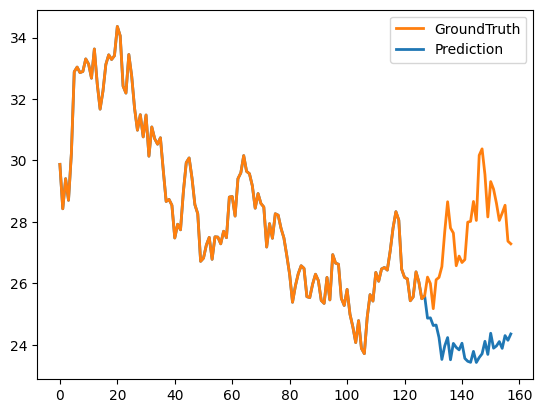

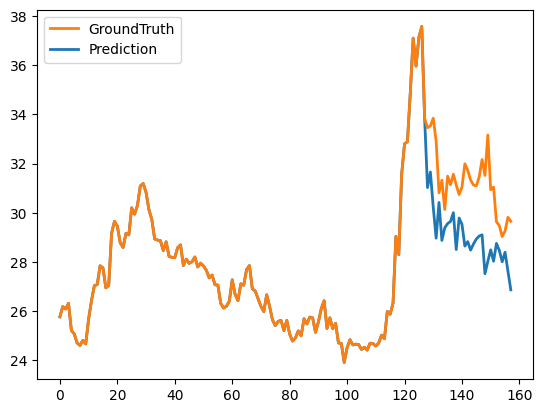

In [57]:
# Initiate the model

exp = Exp_Long_Term_Forecast(args)

# Start training
print("Start training...")
setting = "gateformer_custom"
exp.train(setting)

# Test and visualize
print("Testing...")
exp.test(setting)

# Load best model and predict
model_path = f"./checkpoints/{setting}/checkpoint.pth"
exp.model.load_state_dict(torch.load(model_path))

In [50]:
import matplotlib.dates as mdates
import plotly.graph_objects as go

def predict_next_n_days(model, train_data, df, columns_x, args, plot=True):
    # Get last sequence
    last_seq = df[columns_x[1:]].values[-args.seq_len:]
    last_seq_scaled = train_data.scaler.transform(last_seq)
    last_seq_tensor = torch.tensor(last_seq_scaled).float().unsqueeze(0)

    # Get corresponding dates
    dates_last_seq = df['date'].values[-args.seq_len:]

    # Convert to pandas DatetimeIndex
    dates_pd = pd.to_datetime(dates_last_seq)

    # Generate time features using correct datetime index
    time_features_last = time_features(dates_pd, freq=args.freq)  # <-- Fixed: Pass DatetimeIndex
    time_features_tensor = torch.tensor(time_features_last).float().unsqueeze(0)

    # Move to correct device
    device = next(model.parameters()).device
    last_seq_tensor = last_seq_tensor.to(device)
    time_features_tensor = time_features_tensor.to(device)

    # Dummy decoder input
    dec_inp = torch.zeros((1, args.label_len + args.pred_len, last_seq_tensor.shape[-1])).float().to(device)

    # Run inference
    model.eval()
    with torch.no_grad():
        preds_scaled = model(last_seq_tensor, time_features_tensor, dec_inp, None)

    # Denormalize
    preds_unscaled = train_data.inverse_transform(preds_scaled.cpu().numpy()[0])

    # Generate forecast dates
    last_date = df['date'].iloc[-1]
    forecast_dates = pd.date_range(start=last_date, periods=args.pred_len + 1, freq='D')[1:]

    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'Date': forecast_dates,
        'Predicted_Close': preds_unscaled[:, 0]
    })

    if plot:
        # Convert historical dates to strings for better Plotly compatibility
        hist_dates = df['date'][-100:].dt.strftime('%Y-%m-%d')
        hist_prices = df['Close'][-100:]

        fig = go.Figure()

        # Add historical data
        fig.add_trace(go.Scatter(
            x=hist_dates,
            y=hist_prices,
            mode='lines',
            name='Historical Close Price',
            line=dict(color='#1f77b4', width=2)
        ))

        # Add forecast data
        fig.add_trace(go.Scatter(
            x=forecast_df['Date'].dt.strftime('%Y-%m-%d'),
            y=forecast_df['Predicted_Close'],
            mode='lines+markers',
            name='Forecasted Close Price',
            line=dict(color='purple', width=2, dash='dot'),
            marker=dict(size=6, symbol='circle')
        ))

        # Layout updates
        fig.update_layout(
            title='Stock Price Forecast (Next 15 Days)',
            xaxis_title='Date',
            yaxis_title='Close Price',
            template='plotly_white',
            legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
            hovermode='x unified'
        )

        fig.update_xaxes(tickformat='%b %d', nticks=10, rangeslider_visible=False)
        fig.update_yaxes(gridcolor='#e9e9e9')

        fig.show()

    return forecast_df

In [63]:
import torch

# 1. Initialize the model (must be same architecture as saved model)
exp = Exp_Long_Term_Forecast(args)

# 2. Load pre-trained weights
model_path = "model_weights.pth"
exp.model.load_state_dict(torch.load(model_path))
print("Loaded pre-trained weights from 'model_weights.pth'")

# 3. Start training on new data
print("Start training on new data...")
setting = "gateformer_finetune"  # Change setting name if needed
exp.train(setting)

# 4. (Optional) Save the newly trained weights again
# Test and visualize
print("Testing...")
exp.test(setting)


Use GPU: cuda:0
Loaded pre-trained weights from 'model_weights.pth'
Start training on new data...
train 1492
val 208
test 442
Epoch: 1, Steps: 94 | Train Loss: 0.0499918 Vali Loss: 0.1036718 Test Loss: 0.0721816
Updating learning rate to 4.999950652140343e-05
Validation loss decreased (inf --> 0.103672).  Saving model ...
Epoch: 2, Steps: 94 | Train Loss: 0.0341887 Vali Loss: 0.1052240 Test Loss: 0.0782978
Updating learning rate to 4.9998026105095405e-05
EarlyStopping counter: 1 out of 50
Epoch: 3, Steps: 94 | Train Loss: 0.0277349 Vali Loss: 0.0935306 Test Loss: 0.0720085
Updating learning rate to 4.999555880952023e-05
Validation loss decreased (0.103672 --> 0.093531).  Saving model ...
Epoch: 4, Steps: 94 | Train Loss: 0.0246724 Vali Loss: 0.0978314 Test Loss: 0.0714133
Updating learning rate to 4.99921047320825e-05
EarlyStopping counter: 1 out of 50
Epoch: 5, Steps: 94 | Train Loss: 0.0221747 Vali Loss: 0.0930430 Test Loss: 0.0734553
Updating learning rate to 4.998766400914329e-05
V

DataParallel(
  (module): Model(
    (patch_embedding): PatchEmbedding(
      (padding_patch_layer): ReplicationPad1d((0, 4))
      (value_embedding): Linear(in_features=8, out_features=256, bias=False)
      (position_embedding): PositionalEmbedding()
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (head): FlattenHead(
      (flatten): Flatten(start_dim=-2, end_dim=-1)
      (linear): Linear(in_features=8192, out_features=256, bias=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (project_embedding): DataEmbedding_inverted(
      (value_embedding): Linear(in_features=128, out_features=256, bias=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (gate_w1): Linear(in_features=256, out_features=256, bias=True)
    (gate_w2): Linear(in_features=256, out_features=256, bias=True)
    (gate_w3): Linear(in_features=256, out_features=256, bias=True)
    (gate_w4): Linear(in_features=256, out_features=256, bias=True)
    (gate_sigmoid): Sigmoid()
    (enc_temp

In [65]:
train_data, train_loader = exp._get_data(flag='train')  # Needed for inverse_transform

forecast_df = predict_next_n_days(exp.model, train_data, df, columns_x, args)
print(forecast_df)

train 1492


         Date  Predicted_Close
0  2025-05-17        72.530846
1  2025-05-18        73.196198
2  2025-05-19        71.877090
3  2025-05-20        69.095291
4  2025-05-21        68.766571
5  2025-05-22        68.593948
6  2025-05-23        66.082748
7  2025-05-24        67.407768
8  2025-05-25        67.974876
9  2025-05-26        67.519638
10 2025-05-27        64.955406
11 2025-05-28        61.380196
12 2025-05-29        60.358097
13 2025-05-30        55.220554
14 2025-05-31        53.988518
15 2025-06-01        52.884293
16 2025-06-02        55.982788
17 2025-06-03        56.628136
18 2025-06-04        61.534924
19 2025-06-05        64.085869
20 2025-06-06        62.314625
21 2025-06-07        62.955551
22 2025-06-08        62.361897
23 2025-06-09        63.341240
24 2025-06-10        64.531395
25 2025-06-11        72.209473
26 2025-06-12        77.960915
27 2025-06-13        84.347778
28 2025-06-14        81.124245
29 2025-06-15        85.785370


In [58]:
# After your training completes:
torch.save(exp.model.state_dict(), "model_weights.pth")
print("Model saved as 'model_weights.pth' in current folder")

Model saved as 'model_weights.pth' in current folder
